## NLP : Apply TF-IDF to the Inaugural Corpus 
This project is to: 
1. Define or augment a set of stopwords for this problem
2. Construct a document-by-term matrix (documents will be rows, terms will be columns), along with a vocabulary while controlling for stopwords
3. Write functions to comput TF-IDF and apply those to the document-by-term matrix
4. Find the closest historic inaugural address to the 2017 address by President Trump
5. Learn to use the PCA transformation and plot the inaugural address along the first two principal components

#### Import libraries

In [1]:
import re
import math
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.corpus import inaugural
from nltk.text import Text

In [2]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

porter    = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()
wnl       = nltk.WordNetLemmatizer()

#### Checking inaugural files

In [3]:
inaugural.fileids()[:3]

['1789-Washington.txt', '1793-Washington.txt', '1797-Adams.txt']

In [4]:
inaugural.words(inaugural.fileids()[0])

['Fellow', '-', 'Citizens', 'of', 'the', 'Senate', ...]

#### Making unique stop words and updating them

In [15]:
stop_words = set(stopwords.words('english'))

In [16]:
new = {'.',',',';','-','--','our', 'a', 'their', 'its', 'this', 'that', 'my', 'every', 'all', 'any', 'an', 'no'
       ,'his', 'these', 'your', 'those', 'other', 'one', 'of', 'each', 'through', 'the','!','\',r''#','$', '%',
       '&','/','?', '+', '*','{', '}','~', ':', '(', ')','<','>','=','."','),','000', '1801','1815','1816','1817',
      '1818','2000','120','14th','20','20th','3d','67',',"','[',']','1812','1850','"?', '1774','1776','1778','1787',
      '1861','1868','1873','4','1780','1789','1790','1880','1886','100','125','15th','1890','1893','1896','1897',
      '1898','1899','1907','30th','5','41','4th','50','6th','?"','1933','1941','1945','48','16'}
stop_words.update(new)

_____________________________________________________

#### Creating a vocabulary as a set of all unique stemmed terms in the corpus

In [17]:
vocab = []
for word in nltk.corpus.inaugural.words():
    term = word.lower()
    if term.isalpha() and term not in stop_words and term not in vocab:
        vocab.append(porter.stem(term))

#### Using the vocabulary to read each inaugural address into a dataframe

Each row of the dataframe should represent a document (one of the addresses). Also track the size (length) of each document, since this will be necessary when computing TF.

In [18]:
df = pd.DataFrame()

for speech in inaugural.fileids():
    row = dict.fromkeys(vocab,0)
    for word in nltk.corpus.inaugural.words(speech):
        if porter.stem(word) in vocab:
            row[porter.stem(word)] += 1
    df = df.append(row, ignore_index=True)

In [19]:
df.sample(4)

,abandon,abat,abdic,abey,abhor,abid,abil,abject,abl,abli,...,yield,york,yorktown,young,younger,youngest,youth,zeal,zealous,zone
15,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---
### Compute TF-IDF for the document-term matrix ###

#### Function to compute term frequency (TF) for each document**

In [20]:
# compute term frequency
# inputs: wordvec is a series that contains, for a given doc, 
#                 the word counts for each term in the vocab
#         doclen  is the length of the document (doclen = len(document))
# wordvec = [(fellow:1, citizen:2 ..), (people:1, )]
# returns: a series with new term-frequencies (raw counts divided by doc length)

doclen=df.shape[0]

def computeTF(wordvec, doclen):
    a = wordvec.copy()
    tf = a/doclen
    return tf

#### A function to comput inverse document frequency


In [21]:
import math # may need this for the log function

In [22]:
# input:   document-by-term (row-by-column) dataframe
# returns: dictionary of key-value pairs. Keys are terms in the vocab, values are IDF.

def computeIDF(df):
    idf = {}
    for token in vocab:
        doc_containing_word = 0
        for document in inaugural.fileids():
            if token in nltk.corpus.inaugural.words(document):
                doc_containing_word += 1
        idf[token] = np.log(df.shape[0]/(1 + doc_containing_word))
    return idf

#### Create a new dataframe and populate it with the TF-IDF values for each document-term combination

In [23]:
# length of each document
df["sum"] = df.sum(axis=1)
sizearr =list(df["sum"])

In [24]:
newdf = pd.DataFrame()
idfdict = computeIDF(df)

cols = df.columns
for index, row in df.iterrows():
    newrow = computeTF(row,sizearr[index])
    for c in cols:
        newrow[c] = newrow[c]*idfdict[c]
    newdf = newdf.append(newrow)

In [35]:
#result 
newdf.sample(10)

,abandon,abat,abdic,abey,abhor,abid,abil,abject,abl,abli,...,yield,york,yorktown,young,younger,youngest,youth,zeal,zealous,zone
29,0.000000,0.0,0.0,0.000000,0.0,0.008121,0.000000,0.00000,0.016242,0.0,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0
37,0.001989,0.0,0.0,0.000000,0.0,0.004077,0.004077,0.00000,0.000000,0.0,...,0.001871,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.003609,0.0,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.004969,0.000000,0.0
33,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.002119,0.00000,0.000000,0.0,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0
40,0.001544,0.0,0.0,0.000000,0.0,0.000000,0.003165,0.00000,0.000000,0.0,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0
13,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.001964,0.00000,0.000000,0.0,...,0.000451,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000549,0.0
32,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.0,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0
42,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.0,...,0.002063,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0
26,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.003678,0.00305,0.000000,0.0,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0
20,0.000000,0.0,0.0,0.006882,0.0,0.006882,0.020646,0.00000,0.000000,0.0,...,0.000000,0.0,0.0,0.00208,0.0,0.0,0.0,0.000000,0.000000,0.0


---
### What is the closest inaugural speech to Donald Trump's 2017 address, measured by cosine similarity? 

In [36]:
# President Trump's address is 57 (0-indexed)
# newdf.iloc[57,:].head(100)

#### Creating an array called 'dist' that contains the cosine similarity distance between the 2017 inaugural address (called d1 below) and each of the inaugural addresses

In [25]:
def function(x,y):
    a = x*y
    return sum(a)

In [26]:
d1 = newdf.iloc[57,:]
dist = []
for index,row in newdf.iterrows():
    if index != 57:
        a = function(d1,row)
        b = math.sqrt((row**2).sum())*math.sqrt((d1**2).sum())
        c = a/b
        dist.append(c)

#### Find the 3 closest associated inaugural address, when measured by cosign similarity

In [27]:
a = sorted(dist, reverse=True)
b = a[0:3]

sp = []
for speech in inaugural.fileids():
    sp.append(speech)

for i, val in enumerate(dist):
    if val in b:
        print(sp[i]) 

1993-Clinton.txt
2005-Bush.txt
2013-Obama.txt


#### Why are these documents are "close" to the 2017 address?

The closest speeches are "1993-Clinton.txt", "2005-Bush.txt", and "2013-Obama.txt". We are seeing this output because cosine similarity are the largest, and these speeches contain similar stemmed words with Trump's speech. Also, these are comparatively recent speeches. Considering that vocabulary and overall language change over time, the vocabulary of Trump's speech would be similar to speeches that were made recently. 



---
### Compute the first two principal components of the TF-IDF matrix, and plot each document along each of the PCA components

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [29]:
# your code to compute the PCA goes here
# The result should be X, an array of 2-element arrays
pca = PCA(n_components =2)
X = pca.fit_transform(newdf.fillna(0))

In [30]:
len(X)

58

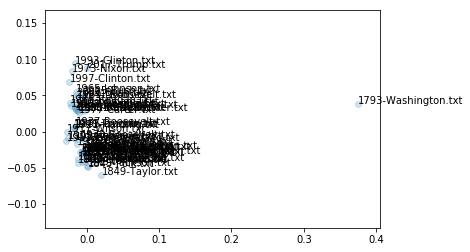

In [31]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.axis('equal');
for i in range(0,58):
    plt.text(X[i,0],X[i,1],inaugural.fileids()[i])